In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gym
import time
import datetime
import copy
import collections
import cv2
from PIL import Image
import base64
import rpyc # For real robot connection
from importnb import Notebook
with Notebook():
    import config
    import models
    from jetbot_sim_environment import JetbotSimEnv
    # from jetbot_data_collection_client import RemoteJetBot # Import your RemoteJetBot class
    from models import SimpleRewardEstimator
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display as ipy_display, clear_output
import ipywidgets as widgets

In [36]:
import logging

# Set the logging level for matplotlib's font manager to WARNING,
# suppressing DEBUG and INFO messages.
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

# You can also suppress DEBUG messages from matplotlib in general if needed
# logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [37]:
# === NEW PARAMETER ===
NUM_EPISODES = 3           # <<<< Number of episodes to run >>>>
# =====================

RUN_ON_REAL_ROBOT = True  # Set to True to run on the actual Jetbot, False for simulation

# --- MPC Parameters ---
PREDICTION_HORIZON = 5     # H: How many steps to look ahead (adjust based on performance)
N_SAMPLES = 3             # N: Number of random action sequences to evaluate
MAX_EPISODE_STEPS = 5     # Maximum steps per episode (Reduced for quicker multi-episode runs)

# --- Real Robot Parameters (only used if RUN_ON_REAL_ROBOT=True) ---
JETBOT_IP = '192.168.68.56' # <<< !!! UPDATE WITH YOUR JETBOT'S IP !!!
ACTION_MAP_REAL = {        # Map discrete actions to motor speeds (Left, Right)
    0: (0.0, 0.0),         # Action 0: Stop
    1: (0.0, 0.1),       # Action 1: turn
}
REAL_ROBOT_FRAME_DELAY = 0.03 # Seconds to wait after sending motor command before getting frame

# Initialize frame_history deque globally if using real robot
# It will be cleared and refilled for each episode.
frame_history = collections.deque(maxlen=config.NUM_PREV_FRAMES + 1)
live_image_widget = widgets.Image(format='jpeg') # Global widget


# --- Environment/Model Setup ---
device = config.DEVICE
print(f"Using device: {device}")

# Load the transformation pipeline from config
transform = config.TRANSFORM

Using device: cuda


In [38]:
# --- Helper Functions (Real Robot - Keep separate if possible) ---
# Placeholder functions - Implement these based on your actual real robot setup if RUN_ON_REAL_ROBOT=True
def get_real_observation_and_update_history(robot, transform, frame_history_deque, image_widget):
    """Gets frame, updates history, returns tensors, updates widget."""
    # Replace with your actual robot communication and image processing
    try:
        # Example placeholder: Replace with actual robot image fetching
        # img_bytes = robot.get_latest_image()
        # --- Placeholder Image Generation ---
        dummy_img = Image.fromarray(np.random.randint(0, 256, (config.RESIZE_HEIGHT, config.RESIZE_WIDTH, 3), dtype=np.uint8))
        buf = io.BytesIO()
        dummy_img.save(buf, format='JPEG')
        img_bytes = buf.getvalue()
        # --- End Placeholder ---

        if not img_bytes: return None, None
        image_widget.value = img_bytes # Update live view

        img_pil = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        img_np = np.array(img_pil) # HWC, RGB, 0-255

        # Apply transform (assumes transform handles normalization and channel order)
        current_frame_tensor = transform(img_np).unsqueeze(0).to(device) # Add batch dim (1, C, H, W)

        # Update history (handle FRAME_SKIP logic if needed - assuming FRAME_SKIP=0 here)
        frame_history_deque.append(current_frame_tensor)

        # Ensure history is full enough before creating prev_frames_tensor
        if len(frame_history_deque) < config.NUM_PREV_FRAMES + 1:
            # Pad with oldest frame if not full enough for initial steps
            while len(frame_history_deque) < config.NUM_PREV_FRAMES + 1:
                 # Pad with the oldest available or a zero tensor if empty
                pad_tensor = frame_history_deque[0].clone() if len(frame_history_deque) > 0 else torch.zeros_like(current_frame_tensor)
                frame_history_deque.appendleft(pad_tensor)

        # Create prev_frames (1, N*C, H, W)
        # Select the N frames *before* the most recent one
        prev_frames_list = [frame_history_deque[i] for i in range(len(frame_history_deque) - config.NUM_PREV_FRAMES -1 , len(frame_history_deque)-1)]
        # Check if list is non-empty before concatenating
        if not prev_frames_list:
             # Handle the very first frame case - maybe return zeros or copy current?
             # Creating zeros might be safer if models expect N*C channels.
             prev_frames_tensor_batch = torch.zeros((1, config.NUM_PREV_FRAMES * 3, config.RESIZE_HEIGHT, config.RESIZE_WIDTH), device=device, dtype=current_frame_tensor.dtype)
        else:
            prev_frames_tensor_batch = torch.cat(prev_frames_list, dim=1).to(device) # Shape (1, N*C, H, W)


        current_frame_tensor_batch = frame_history_deque[-1].clone() # Most recent (1, C, H, W)

        return current_frame_tensor_batch, prev_frames_tensor_batch

    except Exception as e:
        print(f"Error getting real observation: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def estimate_reward_real(obs_tensor, reward_estimator_model):
    """Estimates reward from a real observation tensor using a loaded model."""
    if reward_estimator_model is None:
        print("Warning: Real robot reward estimator not loaded. Returning 0 reward.")
        return 0.0
    try:
        with torch.no_grad():
            reward = reward_estimator_model(obs_tensor).item()
        return reward
    except Exception as e:
        print(f"Error during reward estimation: {e}")
        return 0.0 # Return default reward on error

In [39]:
if RUN_ON_REAL_ROBOT:
    # --- Real Robot Setup ---
    print("Setting up for REAL ROBOT execution (one-time setup)...")
    try:
        # UNCOMMENT and IMPLEMENT your actual robot connection and model loading
        # from jetbot_data_collection_client import RemoteJetBot # Uncomment and ensure correct import
        # robot = RemoteJetBot(JETBOT_IP)
        # print(f"Connected to Jetbot at {JETBOT_IP}")

        # Load the reward estimator model
        # reward_model_path = config.REWARD_ESTIMATOR_PATH # Ensure this path is correct
        # reward_estimator = models.SimpleRewardEstimator().to(device)
        # reward_estimator.load_state_dict(torch.load(reward_model_path, map_location=device))
        # reward_estimator.eval()
        # print(f"Loaded reward estimator from {reward_model_path}")

        # Create the planning environment instance once
        env_for_planning = JetbotSimEnv(max_steps=MAX_EPISODE_STEPS) # Use sim for models
        print("Initialized simulation environment for planning models.")

        # Display the live image widget (if in Jupyter)
        print("Displaying live camera feed widget...")
        ipy_display(live_image_widget)

        # Placeholder Robot if connection fails or is commented out
        if robot is None:
             print("WARNING: Real Robot connection/init commented out or failed. Using placeholder.")
             class PlaceholderRobot:
                 def set_motors(self, left, right): pass #print(f"Placeholder Set Motors: L={left:.2f}, R={right:.2f}")
                 def cleanup(self): print("Placeholder Robot Cleanup")
             robot = PlaceholderRobot() # Use placeholder
             # Ensure planning env is still created if robot fails but RUN_ON_REAL_ROBOT is True
             if env_for_planning is None:
                 env_for_planning = JetbotSimEnv(max_steps=MAX_EPISODE_STEPS)
                 print("Initialized planning env because robot failed.")


    except Exception as e:
        print(f"\nERROR setting up Real Robot: {e}")
        print("Potentially falling back to simulation or exiting.")
        # Decide handling: exit(), fallback, or continue with placeholder
        RUN_ON_REAL_ROBOT = False # Fallback to sim if setup fails hard

if not RUN_ON_REAL_ROBOT: # Simulation chosen OR real robot setup failed
    print("Setting up for SIMULATION execution.")
    if env is None: # Create environment instance only if it doesn't exist
        print("Initializing JetbotSimEnv...")
        env = JetbotSimEnv(max_steps=MAX_EPISODE_STEPS)
        env_for_planning = env # Use the same env for planning and execution in sim
        print("Environment initialized.")
    reward_estimator = None # Sim env calculates its own reward
    robot = None # Ensure robot is None in sim mode

# --- Check Planning Env ---
if env_for_planning is None:
    print("CRITICAL ERROR: Planning environment (env_for_planning) was not initialized.")
    exit()

Setting up for SIMULATION execution.


In [40]:
action_space = env_for_planning.action_space
observation_space = env_for_planning.observation_space # Note: Real robot obs might differ slightly
num_actions = action_space.n
print(f"\n--- Configuration ---")
print(f"Mode: {'REAL ROBOT' if RUN_ON_REAL_ROBOT else 'SIMULATION'}")
print(f"Number of Episodes: {NUM_EPISODES}")
print(f"Max Steps per Episode: {MAX_EPISODE_STEPS}")
print(f"Action space: {action_space} (Size: {num_actions})")
# print(f"Observation space: {observation_space}") # Can be verbose
print(f"Prediction Horizon (H): {PREDICTION_HORIZON}")
print(f"MPC Samples (N): {N_SAMPLES}")
print(f"---------------------\n")




--- Configuration ---
Mode: SIMULATION
Number of Episodes: 3
Max Steps per Episode: 5
Action space: Discrete(2) (Size: 2)
Prediction Horizon (H): 5
MPC Samples (N): 3
---------------------



In [41]:
def evaluate_sequence(initial_state_tensors, action_sequence, planning_env):
    """
    Simulates an action sequence from an initial state using the planning_env's models
    without modifying the planning_env's actual state. Returns total *predicted* reward.
    """
    current_frame, prev_frames = initial_state_tensors
    total_predicted_reward = 0.0
    local_device = planning_env.device # Use the device defined in the planning env

    # Make clones to avoid modifying tensors passed in
    current_frame_sim = current_frame.clone().to(local_device)
    prev_frames_sim = prev_frames.clone().to(local_device)

    # Simulate the sequence step-by-step using the *planning_env*'s models
    for action in action_sequence:
        action_float = planning_env._action_map.get(action, (0.0, 0.0)) # Use planner's map
        action_tensor = torch.tensor([[action_float]], dtype=torch.float32, device=local_device)

        with torch.no_grad():
            # Predict next frame using the planning env's dynamics model
            predicted_next_frame = planning_env._predict_next_frame(
                current_frame_sim, prev_frames_sim, action_tensor
            )
            # Estimate reward for the predicted frame using planning env's reward model
            reward = planning_env._estimate_reward(predicted_next_frame)

        total_predicted_reward += reward # Accumulate reward

        # Update state for the *next* simulation step (Crucial: use predicted frame)
        new_prev_frames = torch.cat(
            [prev_frames_sim[:, 3:, :, :], current_frame_sim],
            dim=1
        )
        prev_frames_sim = new_prev_frames
        current_frame_sim = predicted_next_frame # Next state is the predicted one

    return total_predicted_reward

def select_action_mpc(current_frame_tensor_batch, prev_frames_tensor_batch, planning_env):
    """
    Selects the best action using Random Shooting MPC based on current state.
    """
    best_reward = -float('inf')
    best_action_sequence = None

    initial_state_tensors = (current_frame_tensor_batch, prev_frames_tensor_batch)

    for i in range(N_SAMPLES):
        # Generate a random sequence of actions
        action_sequence = np.random.randint(0, planning_env.action_space.n, size=PREDICTION_HORIZON).tolist()
        # Evaluate the sequence using the simulation model
        current_predicted_reward = evaluate_sequence(initial_state_tensors, action_sequence, planning_env)
        # Keep track of the best sequence found so far
        if current_predicted_reward > best_reward:
            best_reward = current_predicted_reward
            best_action_sequence = action_sequence

    if best_action_sequence is None:
        print("Warning: No best action sequence found. Taking random action.")
        return planning_env.action_space.sample()
    else:
        return best_action_sequence[0]

# In[11]: Plotting Function (plot_episode_sequence) - Unchanged
def plot_episode_sequence(frames_data, total_reward, duration_secs, title_prefix="Episode"):
    """
    Plots a sequence of frames horizontally with annotations.
    """
    num_frames = len(frames_data)
    if num_frames == 0:
        print("No frames collected to plot for this episode.")
        return

    fig_width = max(8, num_frames * 2.5)
    fig_height = 3.5

    fig, axes = plt.subplots(1, num_frames, figsize=(fig_width, fig_height))
    if num_frames == 1: axes = [axes] # Make axes iterable if only one frame

    for i, (frame_img, action, reward, step_num) in enumerate(frames_data):
        ax = axes[i]
        ax.imshow(np.clip(frame_img, 0, 1))
        ax.set_title(f"s{step_num + 1}\na{action} r{reward:.2f}", fontsize=9)
        ax.axis('off')

    fig.suptitle(f"{title_prefix} Finished. Return = {total_reward:.3f} | Duration = {duration_secs:.2f}s\nSequence ({num_frames} frames)", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


Starting MPC Control Loop for 3 episodes...

===== Starting Episode 1/3 =====
Resetting Simulation Environment...


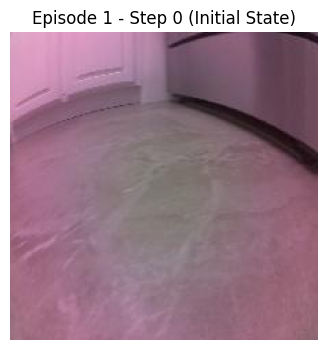

Ep 1 Steps:   0%|          | 0/5 [00:00<?, ?it/s]


--- Episode 1 Summary ---
Episode reached max steps (5).
Finished after 5 steps.
Total Reward: 1.7167
Episode Duration: 0:00:04.476997


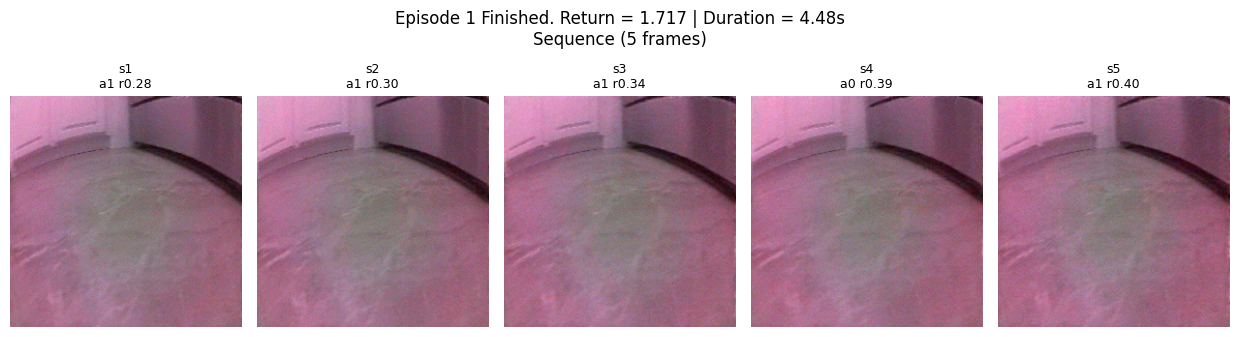


===== Starting Episode 2/3 =====
Resetting Simulation Environment...


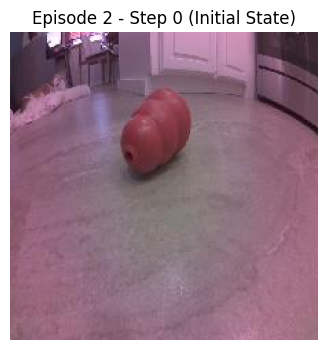

Ep 2 Steps:   0%|          | 0/5 [00:00<?, ?it/s]


--- Episode 2 Summary ---
Episode reached max steps (5).
Finished after 5 steps.
Total Reward: 3.5202
Episode Duration: 0:00:03.824003


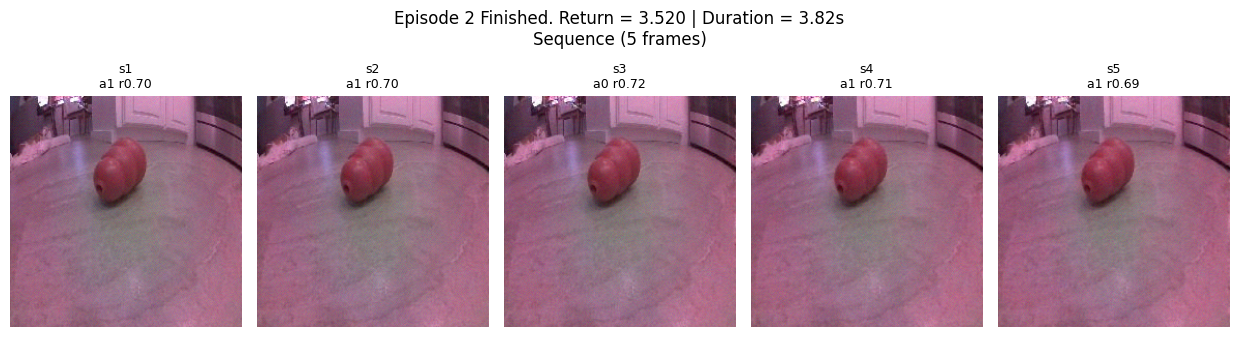


===== Starting Episode 3/3 =====
Resetting Simulation Environment...


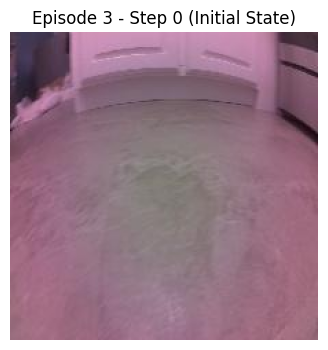

Ep 3 Steps:   0%|          | 0/5 [00:00<?, ?it/s]


--- Episode 3 Summary ---
Episode reached max steps (5).
Finished after 5 steps.
Total Reward: 1.9663
Episode Duration: 0:00:04.199002


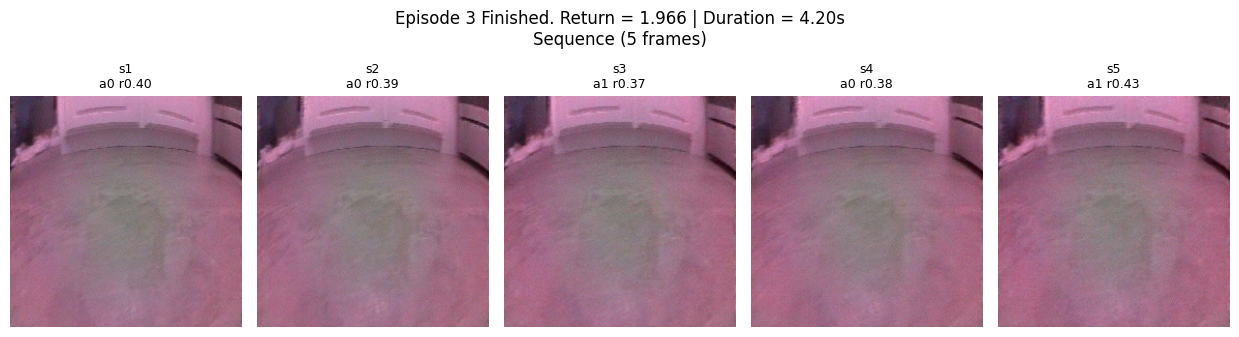


===== All Episodes Completed =====
Simulation environment closed (if applicable).

--- Overall Statistics ---
Rewards per episode: ['1.717', '3.520', '1.966']
Average Reward: 2.4011
Std Dev Reward: 0.7979
Min Reward: 1.7167
Max Reward: 3.5202

MPC Control Script finished.


In [42]:
all_episode_rewards = [] # Optional: Store rewards from all episodes

print(f"\nStarting MPC Control Loop for {NUM_EPISODES} episodes...")

# === Outer Loop for Episodes ===
for episode_num in range(NUM_EPISODES):
    print(f"\n===== Starting Episode {episode_num + 1}/{NUM_EPISODES} =====")

    # --- Re-initialize Episode Variables ---
    current_step = 0
    done = False
    total_actual_reward = 0.0
    episode_frames_data = [] # Reset frame data for the new episode
    current_obs_tensor = None
    prev_frames_tensor = None
    initial_frame_display = None # For showing the first frame of this episode

    # --- Reset Environment & Get Initial State ---
    if not RUN_ON_REAL_ROBOT and env:
        print("Resetting Simulation Environment...")
        sim_obs_np = env.reset()
        current_obs_tensor = env.current_frame_tensor
        prev_frames_tensor = env.prev_frames_tensor
        if current_obs_tensor is not None:
            initial_frame_display = (current_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
        else: done = True; print(f"ERROR: Failed to get initial state from simulation for Episode {episode_num + 1}.")

    elif RUN_ON_REAL_ROBOT and robot:
        print("Initializing real robot state and history buffer...")
        frame_history.clear() # <<< Clear history for the new episode
        # Fill the history buffer for the new episode
        for i in range(config.NUM_PREV_FRAMES + 1):
            # print(f"Getting initial frame {i+1}/{config.NUM_PREV_FRAMES + 1}...") # Verbose
            step_obs_tensor, step_prev_frames = get_real_observation_and_update_history(
                robot, transform, frame_history, live_image_widget # Pass the global deque
            )
            if step_obs_tensor is None:
                 done = True; print(f"ERROR: Failed to get initial frame {i+1} from real robot for Episode {episode_num + 1}."); break
            current_obs_tensor = step_obs_tensor # Keep the latest
            prev_frames_tensor = step_prev_frames
            # Optional small delay, might not be needed if get_real_observation has delays
            # time.sleep(0.1)

        if not done and current_obs_tensor is not None:
            print("Real robot history buffer initialized for episode.")
            initial_frame_display = (current_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
        else:
             done = True; print(f"ERROR: Failed to initialize real robot state for Episode {episode_num + 1}.")

    # Optional: Display the first frame of this episode
    if initial_frame_display is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(np.clip(initial_frame_display, 0, 1))
        plt.title(f"Episode {episode_num + 1} - Step 0 (Initial State)")
        plt.axis('off')
        plt.show()
        # Add initial frame to data? Or just show it separately.
        # episode_frames_data.append((initial_frame_display, -1, 0.0, -1)) # Example: action=-1, step=-1


    # --- Timing for this episode ---
    loop_start_time = datetime.datetime.now()

    # --- Inner Loop for Steps within an Episode ---
    try:
        pbar = tqdm(range(MAX_EPISODE_STEPS), desc=f"Ep {episode_num+1} Steps", disable=done, leave=False) # leave=False cleans up bar after loop
        for step in pbar:
            if done: break
            if current_obs_tensor is None or prev_frames_tensor is None:
                print(f"Error: Missing state tensors at step {current_step} in Ep {episode_num+1}. Aborting episode.")
                done = True
                break

            # 1. Select action using MPC
            plan_start_time = time.time()
            action = select_action_mpc(current_obs_tensor, prev_frames_tensor, env_for_planning)
            plan_duration = time.time() - plan_start_time

            # 2. Execute Action
            reward = 0.0
            info = {}
            next_obs_tensor = None
            next_prev_frames_tensor = None
            current_frame_display_np = None

            if RUN_ON_REAL_ROBOT and robot:
                motor_speeds = ACTION_MAP_REAL.get(action, (0.0, 0.0))
                try:
                    robot.set_motors(motor_speeds[0], motor_speeds[1])
                    time.sleep(REAL_ROBOT_FRAME_DELAY)
                    next_obs_tensor, next_prev_frames_tensor = get_real_observation_and_update_history(
                        robot, transform, frame_history, live_image_widget # Pass global deque
                    )
                    if next_obs_tensor is None: done = True; print(f"\nERROR: Failed state update (Real Robot) Ep {episode_num+1}, Step {current_step}.")
                    else:
                        reward = estimate_reward_real(next_obs_tensor, reward_estimator)
                        current_frame_display_np = (next_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
                except Exception as e:
                     done = True; print(f"\nERROR executing/getting state (Real Robot) Ep {episode_num+1}, Step {current_step}: {e}")

            elif not RUN_ON_REAL_ROBOT and env:
                obs_np, reward, done, info = env.step(action)
                next_obs_tensor = env.current_frame_tensor
                next_prev_frames_tensor = env.prev_frames_tensor
                if next_obs_tensor is not None:
                    current_frame_display_np = (next_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
                else: done = True; print(f"\nERROR: Sim env None obs Ep {episode_num+1}, Step {current_step}.")

            # 3. Record results & Update State for Next Step
            if current_frame_display_np is not None:
                total_actual_reward += reward
                episode_frames_data.append((current_frame_display_np, action, reward, current_step))
                pbar.set_description(f"Ep {episode_num+1} Step {current_step+1}/{MAX_EPISODE_STEPS} | Act: {action} | R: {reward:.3f} | Plan: {plan_duration:.2f}s")
                current_obs_tensor = next_obs_tensor
                prev_frames_tensor = next_prev_frames_tensor
            else:
                print(f"Stopping Ep {episode_num+1} at step {current_step} due to missing frame data.")
                done = True # Ensure loop terminates if frame is missing

            current_step += 1
            if done:
                print(f"Episode {episode_num + 1} finished early at step {current_step} (Done Signal).")

    except KeyboardInterrupt:
        print(f"\nLoop interrupted by user during Episode {episode_num + 1}.")
        # Decide if you want to break the outer loop as well
        raise # Re-raise interrupt to stop outer loop, or use 'break' to only stop inner

    finally:
        # --- Post-Episode Actions (Plotting, Summary) ---
        loop_end_time = datetime.datetime.now()
        episode_duration = loop_end_time - loop_start_time
        all_episode_rewards.append(total_actual_reward) # Store reward for overall stats

        print(f"\n--- Episode {episode_num + 1} Summary ---")
        if not done and current_step >= MAX_EPISODE_STEPS:
             print(f"Episode reached max steps ({MAX_EPISODE_STEPS}).")
        print(f"Finished after {current_step} steps.")
        print(f"Total Reward: {total_actual_reward:.4f}")
        print(f"Episode Duration: {episode_duration}")

        # Plot the sequence for *this* episode
        plot_episode_sequence(
            episode_frames_data,
            total_actual_reward,
            episode_duration.total_seconds(),
            title_prefix=f"Episode {episode_num + 1}" # Add episode number to plot title
        )
        # Small pause between episode plots if desired
        # time.sleep(1)

# === End of Outer Loop for Episodes ===


# --- Final Cleanup (After ALL episodes) ---
print("\n===== All Episodes Completed =====")
if RUN_ON_REAL_ROBOT and robot:
    print("Stopping robot motors (final)...")
    try:
        robot.set_motors(0.0, 0.0)
        if hasattr(robot, 'cleanup'): robot.cleanup()
        print("Robot stopped and cleaned up.")
    except Exception as e: print(f"Error during final robot cleanup: {e}")
elif env:
    # env.close() # Close sim env if needed
    print("Simulation environment closed (if applicable).")

# Optional: Print overall statistics
if all_episode_rewards:
    print("\n--- Overall Statistics ---")
    print(f"Rewards per episode: {[f'{r:.3f}' for r in all_episode_rewards]}")
    print(f"Average Reward: {np.mean(all_episode_rewards):.4f}")
    print(f"Std Dev Reward: {np.std(all_episode_rewards):.4f}")
    print(f"Min Reward: {np.min(all_episode_rewards):.4f}")
    print(f"Max Reward: {np.max(all_episode_rewards):.4f}")

print(f"\nMPC Control Script finished.")
